## NX-414: Brain-like computation and intelligence
Notebook prepared by Alessandro Marin Vargas

# Week 6 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2025

You are required to submit your mini-projects by midnight on 07/05/25. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

In [1]:
import sys
# !{sys.executable} -m pip install gdown h5py

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# %cd /content/drive/MyDrive/NX414/w6-regression/

In [2]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
# import gdown
# url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
# output = "IT_data.h5"
# gdown.download(url, output, quiet=False, fuzzy=True)

In [3]:
# What model you want to use?
# my_model = "pretrained"
my_model = "random"

# Have you already obtained the primary components?
# need_to_extract_pca = "False"
need_to_extract_pca = "True"

### Load the data

In [4]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [5]:
def correct_scaler(images):
    n_samples, n_channels, height, width = images.shape
    scaled_images = np.zeros_like(images, dtype=np.float32)
    
    for c in range(n_channels):
        # Get all pixel values for the current channel
        channel_data = images[:, c, :, :].flatten()
        
        # Calculate mean and standard deviation
        mean = np.mean(channel_data)
        std = np.std(channel_data)
        
        # Apply standardization formula directly
        scaled_images[:, c, :, :] = (images[:, c, :, :] - mean) / std
    
    return scaled_images

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
print("Before standardization:")
print(f"Train shape: {stimulus_train.shape}")
print(f"Train mean: {stimulus_train.mean():.6f}")
print(f"Train std: {stimulus_train.std():.6f}")

print(f"Val shape: {stimulus_val.shape}")
print(f"Val mean: {stimulus_val.mean():.6f}")
print(f"Val std: {stimulus_val.std():.6f}")

print(f"Test shape: {stimulus_test.shape}")
print(f"Test mean: {stimulus_test.mean():.6f}")
print(f"Test std: {stimulus_test.std():.6f}")



stimulus_train = correct_scaler(stimulus_train)
stimulus_val = correct_scaler(stimulus_val)
stimulus_test = correct_scaler(stimulus_test)



# Print statistics after standardization
print("\nAfter standardization:")
print(f"Train shape: {stimulus_train.shape}")
print(f"Train mean: {stimulus_train.mean():.6f}")
print(f"Train std: {stimulus_train.std():.6f}")

print(f"Val shape: {stimulus_val.shape}")
print(f"Val mean: {stimulus_val.mean():.6f}")
print(f"Val std: {stimulus_val.std():.6f}")

print(f"Test shape: {stimulus_test.shape}")
print(f"Test mean: {stimulus_test.mean():.6f}")
print(f"Test std: {stimulus_test.std():.6f}")

Before standardization:
Train shape: (2592, 3, 224, 224)
Train mean: -0.010787
Train std: 0.810623
Val shape: (288, 3, 224, 224)
Val mean: 0.010025
Val std: 0.806754
Test shape: (320, 3, 224, 224)
Test mean: 0.030151
Test std: 0.808420

After standardization:
Train shape: (2592, 3, 224, 224)
Train mean: -0.000000
Train std: 0.999998
Val shape: (288, 3, 224, 224)
Val mean: -0.000000
Val std: 1.000000
Test shape: (320, 3, 224, 224)
Test mean: 0.000000
Test std: 1.000000


In [8]:
y_train = spikes_train
y_val = spikes_val

## Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [9]:
import torch
from torch import nn
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score
import gc
import pickle

In [10]:
# Check PyTorch version
print(f"PyTorch version: {torch.__version__}")

# Check if CUDA is available
if torch.cuda.is_available():
    print(f"CUDA available: Yes")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA available: No")


PyTorch version: 2.7.0+cu118
CUDA available: Yes
CUDA version: 11.8
Number of CUDA devices: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce RTX 4090 Laptop GPU


In [11]:
class FeatureExtractor(nn.Module):
    def __init__(self, model, layers):
        super(FeatureExtractor, self).__init__()
        self.model = model
        self.layers = layers
        self._features = {layer: torch.empty(0) for layer in layers}
        
        for layer_id in layers:
            layer = dict([*self.model.named_modules()])[layer_id]
            layer.register_forward_hook(self.get_hook(layer_id))
    
    def get_hook(self, layer_id):
        def hook(module, input, output):
            self._features[layer_id] = output
        return hook
    
    def forward(self, x):
        self.model(x)
        return [self._features[layer_id] for layer_id in self.layers]

### 2.1 initialize pretrained resnet or random resnet

In [12]:
if my_model == "pretrained":
    pretrained_model = models.resnet50(pretrained=True)
    pretrained_model.eval()

else:
    random_model = models.resnet50(pretrained=False)
    random_model.eval()

print(f"==========================")
print(f"==========================")
print(f"Model used is {my_model} resnet50")
print(f"==========================")
print(f"==========================")

/home/askrbayern/miniforge3/envs/brainlike/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/askrbayern/miniforge3/envs/brainlike/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model used is random resnet50


In [13]:
layers_to_extract = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']

In [14]:
# Convert HxWxC numpy images to CxHxW torch tensors
def preprocess_images(images):
    # Images are already normalized in the dataset
    # Convert to torch tensor and adjust dimensions
    images_tensor = torch.tensor(images, dtype=torch.float32)
    # Our images are already in the format [batch, channels, height, width]
    return images_tensor

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
def extract_features(model, stimulus, batch_size=128):
    # Create feature extractor
    extractor = FeatureExtractor(model, layers_to_extract)
    extractor.to(device)
    extractor.eval()
    
    results = {}
    
    # Process one layer at a time
    for layer_name in layers_to_extract:
        print(f"\nProcessing layer: {layer_name}")
        
        # Create DataLoader
        dataset = TensorDataset(preprocess_images(stimulus))
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        
        # Collect activations
        layer_activations = []
        
        with torch.no_grad():
            for batch in tqdm(dataloader, desc=f"Extracting {layer_name}"):
                batch = batch[0].to(device)
                # Call the entire model to get all activations
                activations = extractor(batch)
                # Find the index of the current layer
                layer_idx = layers_to_extract.index(layer_name)
                # Get activations for the current layer
                layer_act = activations[layer_idx].cpu().numpy()
                
                # Flatten
                if len(layer_act.shape) > 2:
                    if layer_name == 'avgpool':
                        layer_act = layer_act.reshape(layer_act.shape[0], -1)
                    else:
                        layer_act = layer_act.reshape(layer_act.shape[0], -1)
                
                layer_activations.append(layer_act)
        
        # Combine batches
        layer_act = np.vstack(layer_activations)
        
        # Store original features
        results[layer_name] = {
            'features': layer_act
        }
        
        # ===============
        # clean up memory
        del layer_activations, layer_act
        gc.collect()
        torch.cuda.empty_cache()
    
    # Clean up extractor
    del extractor
    gc.collect()
    torch.cuda.empty_cache()
    
    return results

In [17]:
def apply_pca_to_features(train_features, val_features, n_components=1000, already_scaled=False):
    train_pcs = {}
    val_pcs = {}
    
    for layer_name in layers_to_extract:
        X_train = train_features[layer_name]['features']
        X_val = val_features[layer_name]['features']
        
        # If n_components is greater than or equal to the feature dimensions, skip PCA
        if n_components >= X_train.shape[1]:
            print(f"Layer {layer_name}: Skipping PCA as n_components ({n_components}) >= feature dimensions ({X_train.shape[1]})")
            train_pcs[layer_name] = {
                'pcs': X_train,
                'scaler': None,
                'pca': None
            }
            val_pcs[layer_name] = {
                'pcs': X_val
            }
            continue
        
        if already_scaled:
            X_train_scaled = X_train
            X_val_scaled = X_val
            scaler = None
        else:
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)  # Use the same scaler
        
        n_comp = min(n_components, X_train.shape[0], X_train.shape[1])
        pca = PCA(n_components=n_comp)
        train_pcs[layer_name] = {
            'pcs': pca.fit_transform(X_train_scaled),
            'scaler': scaler,
            'pca': pca
        }
        
        val_pcs[layer_name] = {
            'pcs': pca.transform(X_val_scaled)
        }
        
        print(f"Layer {layer_name}: {n_comp} components, {sum(pca.explained_variance_ratio_):.4f} variance explained")
    
    return train_pcs, val_pcs

In [18]:
need_to_extract_pca = False
already_scaled = True

In [20]:
if need_to_extract_pca:
    if my_model == "pretrained":
        print("Extracting features from pre-trained model...")
        pretrained_features_train = extract_features(pretrained_model, stimulus_train)
        pretrained_features_val = extract_features(pretrained_model, stimulus_val)
    else:
        print("Extracting features from randomly initialized model...")
        random_features_train = extract_features(random_model, stimulus_train)
        random_features_val = extract_features(random_model, stimulus_val)
else:
    print("No need to extract pca")

No need to extract pca


In [21]:
if need_to_extract_pca == True:
    print(f"Extracting PCA from {my_model} model...")
    if my_model == "pretrained":
        pretrained_pcs_train, pretrained_pcs_val = apply_pca_to_features(
            pretrained_features_train, 
            pretrained_features_val, 
            n_components=1000,
            already_scaled=already_scaled
        )
    else:
        random_pcs_train, random_pcs_val = apply_pca_to_features(
            random_features_train,
            random_features_val,
            n_components=1000,
            already_scaled=already_scaled
        )
else:
    print("no need to extract again, we load it directly")

no need to extract again, we load it directly


In [22]:
need_to_extract_pca

False

In [23]:
if need_to_extract_pca == True:
    if my_model == "pretrained":
        print("Saving pretrained PCA...")
        with open('pretrained_pcs.pkl', 'wb') as f:
            pickle.dump((pretrained_pcs_train, pretrained_pcs_val), f)
    else:
        print("Saving random PCA...")
        with open('random_pcs.pkl', 'wb') as f:
            pickle.dump((random_pcs_train, random_pcs_val), f)
else:
    if my_model == "pretrained":    
        print("Loading pretrained PCA...")
        with open('pretrained_pcs.pkl', 'rb') as f:
            pretrained_pcs_train, pretrained_pcs_val = pickle.load(f)
    else:
        print("Loading random PCA...")
        with open('random_pcs.pkl', 'rb') as f:
            random_pcs_train, random_pcs_val = pickle.load(f)

print("===============")
print("Completed")

Loading random PCA...
Completed


### 2.2 Now train regressors

- read in train_pc
- train regressor
- test
- return a sample (for visualization purpose)
- return metrics

What are these metrics returned?
- 1. a vector of size n, correlations for all n neurons
- 2. a vector of size n, exp_variances for all nn eurons
- for these neurons, we obtain the average
    - 3. a scalar of mean correlation
    - 4. a scalar of mean variance

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score
from tqdm import tqdm

from sklearn.linear_model import Ridge

In [25]:
def predict_neural_activity(layer_pcs_train, layer_pcs_val, y_train, y_val, regressor="Linear", alpha=1.0, sample_to_plot=0):
    layer_metrics = {}
    sample_predictions = {}
    
    for layer_name in layers_to_extract:
        print(f"{layer_name}")
        X_train_pcs = layer_pcs_train[layer_name]['pcs']
        X_val_pcs = layer_pcs_val[layer_name]['pcs']
        

        if X_train_pcs.shape[1] != X_val_pcs.shape[1]:
            print(f"Warning: Feature mismatch for {layer_name}. Training: {X_train_pcs.shape[1]}, Validation: {X_val_pcs.shape[1]}")
            min_components = min(X_train_pcs.shape[1], X_val_pcs.shape[1])
            X_train_pcs = X_train_pcs[:, :min_components]
            X_val_pcs = X_val_pcs[:, :min_components]
            print(f"Using {min_components} components for both sets")
        
        correlations = []
        exp_variances = []
        sample_neuron_predictions = []  # Store predictions for all neurons for a specific sample
        
        for neuron in tqdm(range(y_train.shape[1]), desc=f"Training models for {layer_name}"):
            # Choose regressor based on parameter
            if regressor == "Linear":
                lr = LinearRegression()
            elif regressor == "Ridge":
                lr = Ridge(alpha=alpha)
            else:
                raise ValueError(f"Unsupported regressor: {regressor}")
                
            lr.fit(X_train_pcs, y_train[:, neuron])
            
            # Predict on validation set
            y_pred = lr.predict(X_val_pcs)
            y_true = y_val[:, neuron]
            
            # Calculate Pearson correlation coefficient and explained variance
            correlation = np.corrcoef(y_pred, y_true)[0, 1]  # Pearson correlation coefficient
            exp_var = explained_variance_score(y_true, y_pred)
            
            correlations.append(correlation)
            exp_variances.append(exp_var)
            
            # Save prediction for the specific sample
            sample_neuron_predictions.append(y_pred[sample_to_plot])
        
        layer_metrics[layer_name] = {
            'correlations': correlations,
            'exp_variances': exp_variances,
            'mean_correlation': np.mean(correlations),
            'std_correlation': np.std(correlations),
            'mean_exp_variance': np.mean(exp_variances),
            'std_exp_variance': np.std(exp_variances)
        }
        
        sample_predictions[layer_name] = np.array(sample_neuron_predictions)
        
        print(f"Mean Correlation: {np.mean(correlations):.4f} ± {np.std(correlations):.4f}")
        print(f"Mean Explained Variance: {np.mean(exp_variances):.4f} ± {np.std(exp_variances):.4f}")


    # PLOT a single case just to visualize... not that meaningful tho
    
    # Plot predictions for all neurons from each layer for a specific sample
    plt.figure(figsize=(14, 7))
    
    # Plot true values
    neurons = np.arange(y_val.shape[1])
    plt.plot(neurons, y_val[sample_to_plot], 'ko-', label='True Activity', linewidth=2)
    
    # Plot predictions from each layer
    colors = plt.cm.tab10(np.linspace(0, 1, len(layers_to_extract)))
    for i, layer_name in enumerate(layers_to_extract):
        plt.plot(neurons, sample_predictions[layer_name], 'o-', 
                 color=colors[i], label=f'{layer_name} Prediction',
                 alpha=0.8)
    
    plt.title(f'Neural Activity Predictions for Sample {sample_to_plot}')
    plt.xlabel('Neuron Number')
    plt.ylabel('Neural Activity')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('all_layer_predictions.png')
    plt.show()
    
    return layer_metrics


In [26]:
def plot_layer_metrics(my_model, layer_metrics, metric='exp_variances'):
    # Calculate mean metrics for each layer
    layers = layers_to_extract
    
    # Map metric parameter to the actual keys in the metrics dictionaries
    if metric == 'exp_variances' or metric == 'exp_variance':
        mean_key = 'mean_exp_variance'
        std_key = 'std_exp_variance'
        dist_key = 'exp_variances'
    elif metric == 'correlation':
        mean_key = 'mean_correlation'
        std_key = 'std_correlation'
        dist_key = 'correlations'
    else:
        mean_key = f'mean_{metric}'
        std_key = f'std_{metric}'
        dist_key = metric
    
    # Prepare x-axis with layer names
    x = np.arange(len(layers))
    width = 0.35
    
    # Create plot
    plt.figure(figsize=(12, 6))
    
    # Get means and standard deviations for the model type
    model_means = [layer_metrics[layer][mean_key] for layer in layers]
    model_stds = [layer_metrics[layer][std_key] for layer in layers]
    
    # Plot based on model type
    if my_model == "pretrained":
        bars = plt.bar(x, model_means, width, label='Pre-trained', yerr=model_stds, capsize=5)
    elif my_model == "random":
        bars = plt.bar(x, model_means, width, label='Random', yerr=model_stds, capsize=5)
    
    plt.xlabel('Network Layer')
    plt.ylabel('Mean ' + ('Correlation' if 'correlation' in metric else 'Explained Variance'))
    plt.title('Performance Across Layers')
    plt.xticks(x, layers, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 3 Plot results

### 3.1 Ridge

Predicting with randomly initialized model features...
conv1


Training models for conv1: 100%|██████████| 168/168 [00:04<00:00, 40.38it/s]


Mean Correlation: 0.2843 ± 0.1247
Mean Explained Variance: 0.0921 ± 0.0800
layer1


Training models for layer1: 100%|██████████| 168/168 [00:03<00:00, 52.79it/s]


Mean Correlation: 0.4021 ± 0.1339
Mean Explained Variance: 0.1658 ± 0.1001
layer2


Training models for layer2: 100%|██████████| 168/168 [00:02<00:00, 58.35it/s]


Mean Correlation: 0.4281 ± 0.1369
Mean Explained Variance: 0.1927 ± 0.1106
layer3


Training models for layer3: 100%|██████████| 168/168 [00:02<00:00, 57.79it/s]


Mean Correlation: 0.4494 ± 0.1423
Mean Explained Variance: 0.2152 ± 0.1321
layer4


Training models for layer4: 100%|██████████| 168/168 [00:02<00:00, 60.61it/s]


Mean Correlation: 0.4167 ± 0.1463
Mean Explained Variance: 0.1756 ± 0.1382
avgpool


Training models for avgpool: 100%|██████████| 168/168 [00:02<00:00, 69.33it/s]


Mean Correlation: 0.2375 ± 0.1133
Mean Explained Variance: 0.0522 ± 0.0480


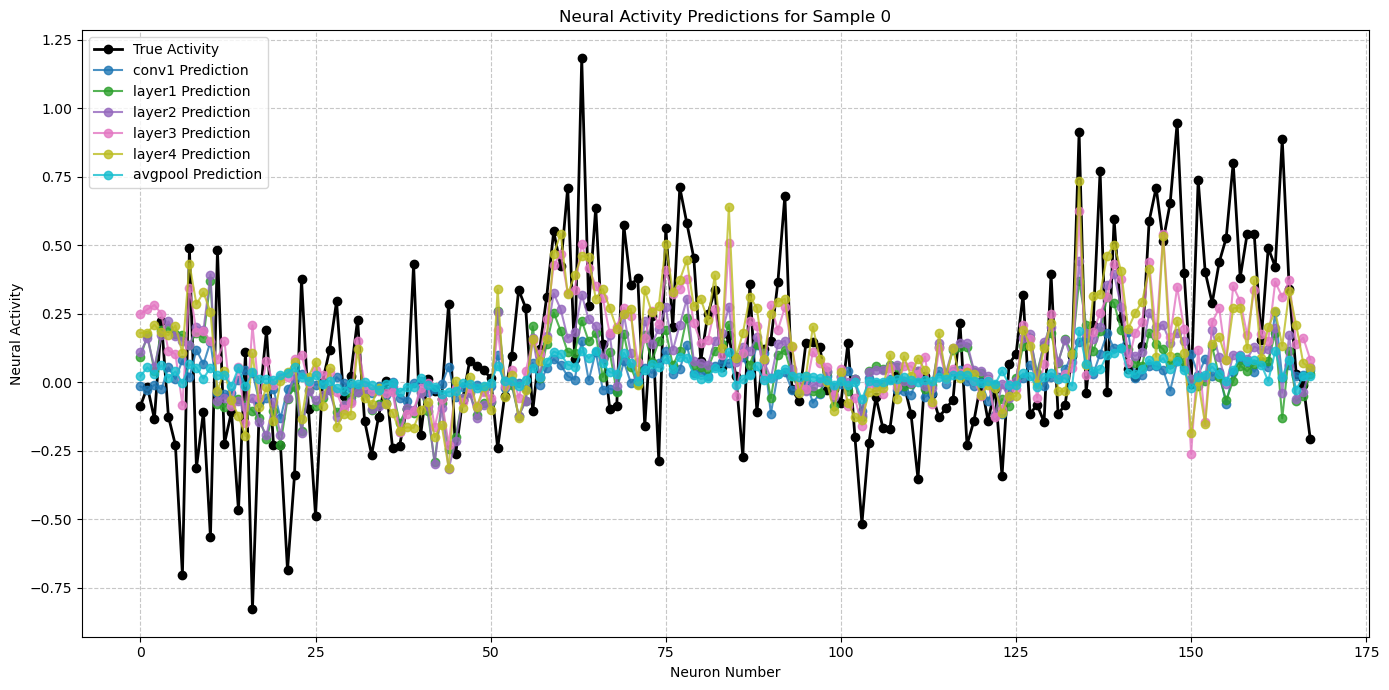

In [27]:
if my_model == "pretrained":
    print("Predicting with pre-trained model features...")
    layer_metrics = predict_neural_activity(pretrained_pcs_train, pretrained_pcs_val, y_train, y_val, regressor="Ridge", alpha=300000)
else:
    print("Predicting with randomly initialized model features...")
    layer_metrics = predict_neural_activity(random_pcs_train, random_pcs_val, y_train, y_val, regressor="Ridge", alpha=300000)

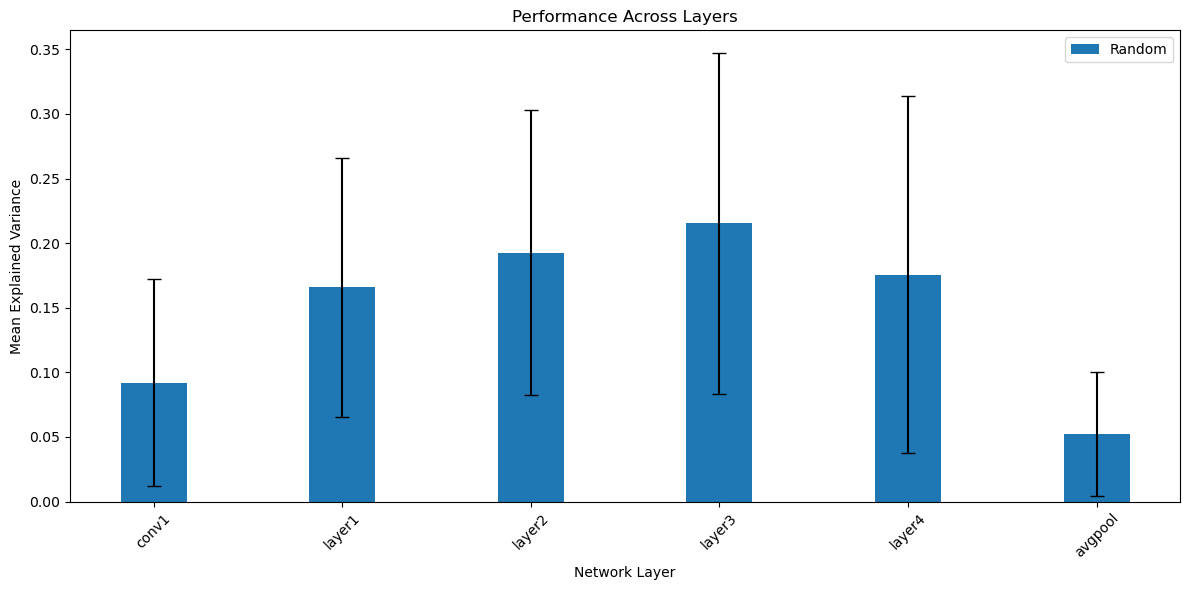

In [28]:
plot_layer_metrics(my_model, layer_metrics=layer_metrics, metric='exp_variances')

In [29]:
# Plot the layer3 metrics
layer3_data = layer_metrics['layer3']
print("Layer 3 Mean Correlation:", layer3_data['mean_correlation'])
print("Layer 3 Mean Explained Variance:", layer3_data['mean_exp_variance'])

Layer 3 Mean Correlation: 0.44939245890654417
Layer 3 Mean Explained Variance: 0.21524165038551604


In [30]:
# Plot the layer 4 metrics
layer4_data = layer_metrics['layer4']
print("Layer 4 Mean Correlation:", layer4_data['mean_correlation'])
print("Layer 4 Mean Explained Variance:", layer4_data['mean_exp_variance'])

Layer 4 Mean Correlation: 0.41673671372350396
Layer 4 Mean Explained Variance: 0.17559257788317545


In [31]:
# Plot the final ave pool layer metrics
avg_pool_data = layer_metrics['avgpool']
print("Average Pool Mean Correlation:", avg_pool_data['mean_correlation'])
print("Average Pool Mean Explained Variance:", avg_pool_data['mean_exp_variance'])

Average Pool Mean Correlation: 0.2374867728114653
Average Pool Mean Explained Variance: 0.05221307384116309


### 3.2 Linear

Predicting with randomly initialized model features...
conv1


Training models for conv1: 100%|██████████| 168/168 [00:28<00:00,  5.83it/s]


Mean Correlation: 0.2113 ± 0.1242
Mean Explained Variance: -0.0982 ± 0.1314
layer1


Training models for layer1: 100%|██████████| 168/168 [00:32<00:00,  5.18it/s]


Mean Correlation: 0.4088 ± 0.1484
Mean Explained Variance: 0.1379 ± 0.1575
layer2


Training models for layer2: 100%|██████████| 168/168 [00:45<00:00,  3.68it/s]


Mean Correlation: 0.4415 ± 0.1519
Mean Explained Variance: 0.1863 ± 0.1577
layer3


Training models for layer3: 100%|██████████| 168/168 [00:38<00:00,  4.34it/s]


Mean Correlation: 0.4256 ± 0.1440
Mean Explained Variance: 0.1614 ± 0.1516
layer4


Training models for layer4: 100%|██████████| 168/168 [00:29<00:00,  5.64it/s]


Mean Correlation: 0.3907 ± 0.1462
Mean Explained Variance: 0.1102 ± 0.1572
avgpool


Training models for avgpool: 100%|██████████| 168/168 [00:39<00:00,  4.26it/s]


Mean Correlation: 0.3180 ± 0.1434
Mean Explained Variance: -0.0961 ± 0.2007


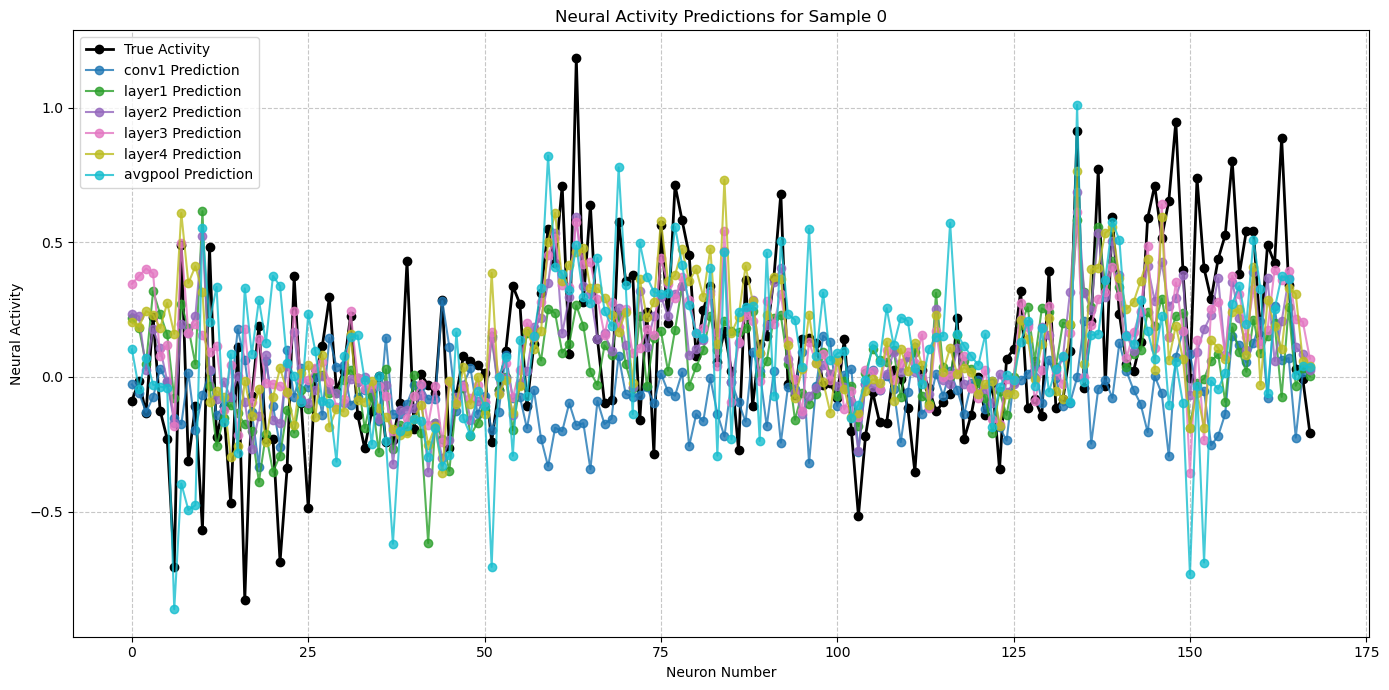

In [32]:
if my_model == "pretrained":
    print("Predicting with pre-trained model features...")
    layer_metrics = predict_neural_activity(pretrained_pcs_train, pretrained_pcs_val, y_train, y_val)
else:
    print("Predicting with randomly initialized model features...")
    layer_metrics = predict_neural_activity(random_pcs_train, random_pcs_val, y_train, y_val)

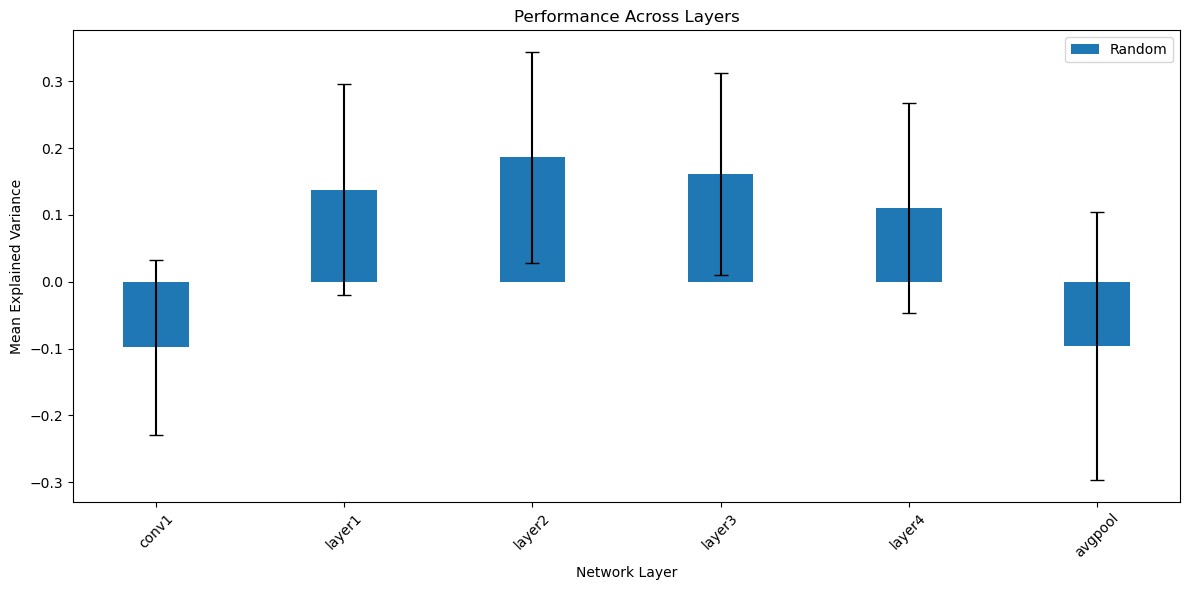

In [33]:
plot_layer_metrics(my_model, layer_metrics=layer_metrics, metric='exp_variances')

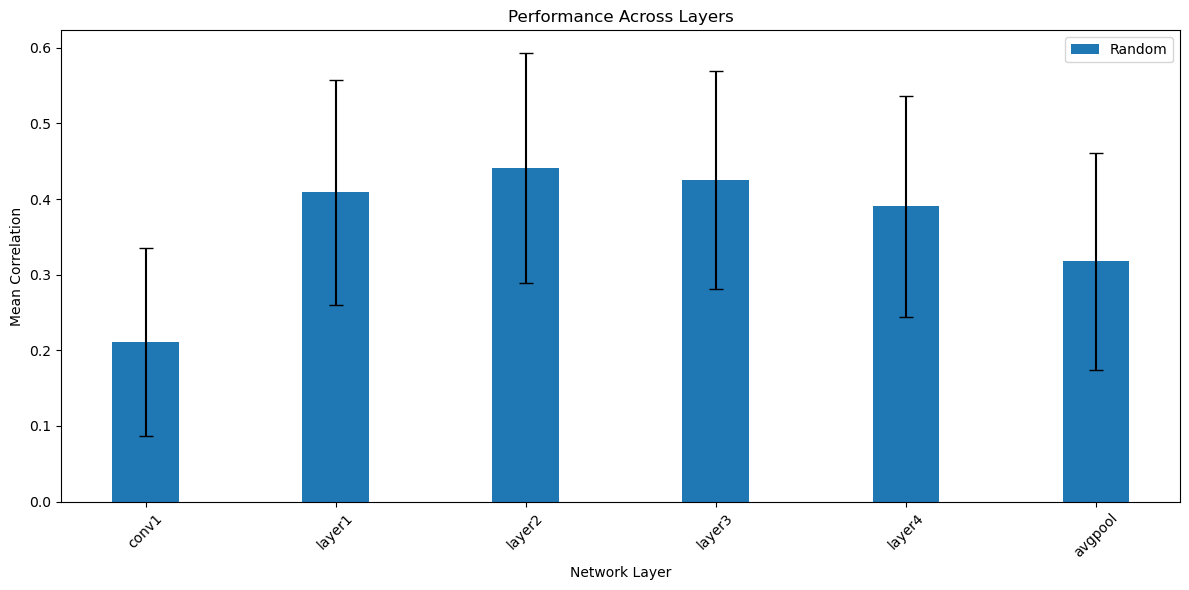

In [34]:
plot_layer_metrics(my_model, layer_metrics=layer_metrics, metric='correlation')

In [35]:
# Plot the layer3 metrics
layer3_data = layer_metrics['layer3']
print("Layer 3 Mean Correlation:", layer3_data['mean_correlation'])
print("Layer 3 Mean Explained Variance:", layer3_data['mean_exp_variance'])

Layer 3 Mean Correlation: 0.42556236767206396
Layer 3 Mean Explained Variance: 0.16137916098038355


In [36]:
# Plot the layer4  metrics
layer4_data = layer_metrics['layer4']
print("Layer 4 Mean Correlation:", layer4_data['mean_correlation'])
print("Layer 4 Mean Explained Variance:", layer4_data['mean_exp_variance'])

Layer 4 Mean Correlation: 0.3907005249360412
Layer 4 Mean Explained Variance: 0.1102292292884418


In [37]:
# Plot the ave pool metrics
avg_pool_data = layer_metrics['avgpool']
print("Average Pool Mean Correlation:", avg_pool_data['mean_correlation'])
print("Average Pool Mean Explained Variance:", avg_pool_data['mean_exp_variance'])

Average Pool Mean Correlation: 0.31799462407197554
Average Pool Mean Explained Variance: -0.09608231272016253
